![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/generative-ai/Medical_Chatbot_RAG_JohnSnowLabs_LangChain.ipynb)

# Medical Chatbot RAG JohnSnowLabs

In [ ]:
!pip install -q --upgrade pip
!pip install -q --upgrade johnsnowlabs==5.1.9
!pip install -q --upgrade langchain openai tiktoken faiss-cpu
!pip install -q --upgrade unstructured==0.10.18
!pip install -q --upgrade ctransformers
!pip install -q --upgrade transformers einops
!pip install -q --upgrade bitsandbytes accelerate
!pip install -q --upgrade datasets

# restart session after installing evertything
from johnsnowlabs import nlp
nlp.start(
    hardware_target = "cpu"
)

# restart session after installing evertything
import os
os.kill(os.getpid(), 9)


In [ ]:
from johnsnowlabs import nlp
spark = nlp.start(
    hardware_target = "cpu"
)
spark

👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.1.4, running on ⚡ PySpark==3.1.2


#  Johnsnowlabs LangChain Integrations

Johnsnowlabs provides the following components which can be used inside the [Langchain Framework](https://www.langchain.com/) for scalable pre-processing&embedding on
[spark clusters](https://spark.apache.org/) as Agent Tools and Pipeline components. With this you can create Easy-Scalable&Production-Grade LLM&RAG applications.
See the [Langchain with Johnsnowlabs Tutorial Notebook](https://github.com/JohnSnowLabs/johnsnowlabs/blob/main/notebooks/langchain_with_johnsnowlabs.ipynb)



## JohnSnowLabsLangChainCharSplitter
Pre-Process you documents in a scalable fashion in Langchain
based on [Spark-NLP's DocumentCharacterTextSplitter](https://sparknlp.org/docs/en/annotators#documentcharactertextsplitter) and supports all of it's [parameters](https://sparknlp.org/api/python/reference/autosummary/sparknlp/annotator/document_character_text_splitter/index.html#sparknlp.annotator.document_character_text_splitter.DocumentCharacterTextSplitter)

```python
from langchain.document_loaders import TextLoader
loader = TextLoader('/content/state_of_the_union.txt')
documents = loader.load()

# Create Pre-Processor which is connected to spark-cluster
from johnsnowlabs.llm import embedding_retrieval
processor = embedding_retrieval.JohnSnowLabsLangChainCharSplitter(
    chunk_overlap=2,
    chunk_size=20,
    explode_splits=True,
    keep_seperators=True,
    patterns_are_regex=False,
    split_patterns=["\n\n", "\n", " ", ""],
    trim_whitespace=True,
)

# Process document distributed on a spark-cluster
pre_processed_docs = jsl_splitter.split_documents(documents)
```

## JohnSnowLabsLangChainCustomDocumentSplitter

An ultimate solution for tailored document segmentation in the world of medical and clinical notes within the RAG architecture. Based on Healthcare NLP library's [Document Splitter](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/38.InternalDocumentSplitter.ipynb), it is an innovative annotator designed to effortlessly break down extensive documents into manageable segments. Empowering users with the ability to define custom separators, respecting the sentence boundaries or max number of tokens (both BPE and classic token) this tool seamlessly divides texts, ensuring each chunk adheres to specific criteria.

InternalDocumentSplitter has a setSplitMode method to decide how to split documents.

**Parameters**:

- `chunkSize`: Size of each chunk of text. This param is applicable only for "recursive" splitMode.
- `chunkOverlap`: Length of the overlap between text chunks, by default `0`. This param is applicable only for `recursive` splitMode.
- `splitPatterns`: Patterns to split the document.
patternsAreRegex. Whether to interpret the split patterns as regular expressions, by default `True`.
- `keepSeparators`: Whether to keep the separators in the final result , by default `True`. This param is applicable only for "recursive" splitMode.
- `explodeSplits`: Whether to explode split chunks to separate rows , by default `False`.
- `trimWhitespace`: Whether to trim whitespaces of extracted chunks , by default `True`.
- `splitMode`: The split mode to determine how text should be segmented. Default: 'regex'. It should be one of the following values:
  - "char": Split text based on individual characters.
  - "token": Split text based on tokens. You should supply tokens from inputCols.
  - "sentence": Split text based on sentences. You should supply sentences from inputCols.
  - "recursive": Split text recursively using a specific algorithm.
  - "regex": Split text based on a regular expression pattern.
- `sentenceAwareness`: Whether to split the document by sentence awareness if possible.
  - If true, it can stop the split process before maxLength.
  - If true, you should supply sentences from inputCols. Default: False.
  - This param is not applicable only for `regex` and `recursive` splitMode.
- `maxLength`: The maximum length allowed for spitting. The mode in which the maximum length is specified:
  - "char": Maximum length is measured in characters. Default: `512`
  - "token": Maximum length is measured in tokens. Default: `128`
  - "sentence": Maximum length is measured in sentences. Default: `8`
- `customBoundsStrategy`: The custom bounds strategy for text splitting using regular expressions. This param is applicable only for `regex` splitMode.
- `caseSensitive`: Whether to use case sensitive when matching regex, by default `False`. This param is applicable only for `regex` splitMode.
-  `metaDataFields`: Metadata fields to add specified data in columns to the metadata of the split documents.         You should set column names to read columns.

```python
from langchain.document_loaders import TextLoader

loader = TextLoader('/content/state_of_the_union.txt')
documents = loader.load()

from johnsnowlabs.llm import embedding_retrieval

processor = embedding_retrieval.JohnSnowLabsLangChainCustomDocumentSplitter(
    .setInputCols("document")\
    .setOutputCol("splits")\
    .setSplitMode("regex")\
    .setSplitPatterns(["PRESENT ILLNESS:", "SUBJECTIVE:", "MEDICAL HISTORY:", "MEDICATIONS:"])\
    .setCaseSensitive(True) \
    .setCustomBoundsStrategy("prepend")\
    .setExplodeSplits(True) \
)

# Process document distributed on a spark-cluster
pre_processed_docs = jsl_splitter.split_documents(documents)
```

## JohnSnowLabsLangChainEmbedder
Scalable Embedding computation with [any Sentence Embedding](https://nlp.johnsnowlabs.com/models?task=Embeddings) from John Snow Labs.
You must provide the **NLU reference** of a sentence embeddings to load it.
You can start a spark session by setting `hardware_target` as one of `cpu`, `gpu`, `apple_silicon`, or `aarch` on localhost environments.
For clusters, you must setup the cluster-env correctly, using [nlp.install_to_databricks()](https://nlp.johnsnowlabs.com/docs/en/jsl/install_advanced#into-a-freshly-created-databricks-cluster-automatically) is recommended.


```python
# Create embedder connected to spark-cluster

from johnsnowlabs.llm import embedding_retrieval

embeddings =  embedding_retrieval.JohnSnowLabsLangChainEmbedder('en.embed_sentence.bert_base_uncased',hardware_target='cpu')
```

```python
# Compute Embeddings distributed
from langchain.vectorstores import FAISS
retriever = FAISS.from_documents(pre_processed_docs, embeddings).as_retriever()

# Create A tool
from langchain.agents.agent_toolkits import create_retriever_tool
tool = create_retriever_tool(retriever,
  "search_state_of_union",
  "Searches and returns documents regarding the state-of-the-union."
)

# Use Create LLM Agent with the Tool
from langchain.agents.agent_toolkits import create_conversational_retrieval_agent
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(openai_api_key='YOUR_API_KEY')
agent_executor = create_conversational_retrieval_agent(llm, [tool], verbose=True)
result = agent_executor({"input": "what did the president say about going to east of Columbus?"})
result['output']
```

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/healthcare-nlp/data/pubmed_diabetes_1000_meta.csv

### Dataset

In [ ]:
import pandas as pd

df = spark.createDataFrame(pd.read_csv("./pubmed_diabetes_1000_meta.csv", usecols=range(1,6)))

df.orderBy("pubmed_id").write.mode("overwrite").parquet('pubmed_diabetes_1000_meta.parquet')


In [ ]:
df = spark.read.parquet("pubmed_diabetes_1000_meta.parquet")

df.show(10,truncate=25)

+----------+-------------------------+-----------+-------------------------+-------------------------+
| pubmed_id|                 abstract|    pubdate|                    title|          fulljournalname|
+----------+-------------------------+-----------+-------------------------+-------------------------+
|PMC5770032|Gestational diabetes m...|2018 Jan 16|Increased risk of isch...|            PLoS Medicine|
|PMC5781289|Depression is a preval...|2018 Jan 24|Association of depress...|Cardiovascular Diabeto...|
|PMC5789627|Gestational diabetes i...|2018 Jan 30|The clinical course an...|  BMC Endocrine Disorders|
|PMC5797393|It has been reported t...| 2018 Feb 2|Contiguous 22.1-kb del...|           BMC Nephrology|
|PMC5798333|We report a disease-ca...|2018 Jan 16|MAFA missense mutation...|Proceedings of the Nat...|
|PMC8249442|Periodontal disease ha...| 2021 Jul 1|Bidirectional associat...|       Scientific Reports|
|PMC8257029|This article aims to n...| 2021 Jul 1|Oral Health Messiers: .

In [ ]:
from langchain.document_loaders import PySparkDataFrameLoader
loader = PySparkDataFrameLoader(spark, df, page_content_column="abstract")
documents = loader.load()

In [ ]:
documents[1]

Document(page_content='Depression is a prevalent, independent predictor of mortality in patients with heart failure (HF). Depression is also common in type 2 diabetes mellitus (T2DM), which is itself an important risk factor for HF. However, association of depression with incident HF in T2DM is undefined. The aim of the present study was to evaluate the predictive value of depression in predicting incident HF in a community-based cohort of asymptomatic patients with T2DM.\nWe prospectively recruited 274 asymptomatic T2DM patients\xa0≥\xa065\xa0years (age 71\xa0±\xa04\xa0year, 56% men) with preserved EF and no ischemic heart disease from a community-based population. The Patient Health Questionnaire 9 (PHQ-9) was used to detect depression, and LV dysfunction was sought with a comprehensive echocardiogram, including LV hypertrophy (LVH) and subclinical diastolic function (E/e′). Over a median follow-up of 1.5\xa0years (range 0.5–3), 20 patients were lost to follow-up and 254 individuals 

In [ ]:
documents[1].metadata

{'pubmed_id': 'PMC5781289',
 'pubdate': '2018 Jan 24',
 'title': 'Association of depression with evolution of heart failure in patients with type 2 diabetes mellitus',
 'fulljournalname': 'Cardiovascular Diabetology'}

In [ ]:
len(documents)

1000

In [ ]:
from johnsnowlabs.llm import embedding_retrieval

jsl_splitter = embedding_retrieval.JohnSnowLabsLangChainCharSplitter(chunk_size=500,
                                                                     chunk_overlap=50)
texts = jsl_splitter.split_documents(documents)


Spark Session already created, some configs may not take.


In [ ]:
from johnsnowlabs.llm import embedding_retrieval

embeddings =  embedding_retrieval.JohnSnowLabsLangChainEmbedder('en.embed_sentence.instructor_base')

Spark Session already created, some configs may not take.
instructor_base download started this may take some time.
Approximate size to download 387.7 MB
[OK!]


In [ ]:
len(embeddings.embed_query('test'))

768

In [ ]:
len(texts)

4498

In [ ]:
texts[:3]

[Document(page_content='Gestational diabetes mellitus (GDM) is associated with developing type 2 diabetes, but very few studies have examined its effect on developing cardiovascular disease.', metadata={'pubmed_id': 'PMC5770032', 'pubdate': '2018 Jan 16', 'title': 'Increased risk of ischemic heart disease, hypertension, and type 2 diabetes in women with previous gestational diabetes mellitus, a target group in general practice for preventive interventions: A population-based cohort study', 'fulljournalname': 'PLoS Medicine'}),
 Document(page_content='We conducted a retrospective cohort study utilizing a large primary care database in the United Kingdom. From 1 February 1990 to 15 May 2016, 9,118 women diagnosed with GDM were identified and randomly matched with 37,281 control women by age and timing of pregnancy (up to 3 months). Adjusted incidence rate ratios (IRRs) with 95% confidence intervals (CIs) were calculated for cardiovascular risk factors and cardiovascular disease. Women wi

### with FAISS vector db

In [ ]:
#!pip install -q faiss-cpu

In [ ]:
%%time
from langchain.vectorstores import FAISS

db = FAISS.from_documents(texts, embeddings)
faiss_retriever = db.as_retriever(search_kwargs={"k": 3})

#!zip -r faiss_retriever.zip faiss_retriever

CPU times: user 8.75 s, sys: 964 ms, total: 9.71 s
Wall time: 27min 4s


In [ ]:
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/healthcare-nlp/data/faiss_retriever_db_diabetes.vs.zip -O faiss_retriever_db_diabetes.vs.zip

In [ ]:
!unzip -o faiss_retriever_db_diabetes.vs

Archive:  faiss_retriever_db_diabetes.vs.zip
  inflating: faiss_retriever_db_diabetes.vs/index.faiss  
  inflating: faiss_retriever_db_diabetes.vs/index.pkl  


In [ ]:
%%time
from langchain.vectorstores import FAISS

db = FAISS.load_local("faiss_retriever_db_diabetes.vs", embeddings)
faiss_retriever = db.as_retriever(search_kwargs={"k": 10})

CPU times: user 28.3 ms, sys: 11.2 ms, total: 39.5 ms
Wall time: 49.7 ms


In [ ]:
faiss_retriever.get_relevant_documents("causes of diabetes")

[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'source': 'diabetes_txt_files/PMC6308908_abstract.txt', 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}),
 Document(page_content='patients with type\xa02 diabetes and those who had prediabetes.', metadata={'source': 'diabetes_txt_files/PMC7378450_abstract.txt', 'pubmed_id': 'PMC7378450', 'pubdate': '2020 Jan 13', 'title': 'Association between mean platelet volume in the pathogenesis of type\xa02 diabetes mellitus and diabetic macrovascular complications in Japanese patients', 'fulljournalname': 'Journal of Diabetes Investigation'}),
 Document(page_content='diabetes-related comorbidities, and well-being.', metadata={'source': 'diabetes_txt_files/PMC7730786_abstract.txt', 'pubmed_id': 'PMC7730786', 'pubdate': '2020 Dec 10', 'title': 'Different

In [ ]:
results = faiss_retriever.get_relevant_documents("causes of diabetes")

pd.DataFrame([doc.metadata for doc in results])

,source,pubmed_id,pubdate,title,fulljournalname
0,diabetes_txt_files/PMC6308908_abstract.txt,PMC6308908,2018 Sep 19,Compensatory mechanisms for methylglyoxal deto...,Molecular Metabolism
1,diabetes_txt_files/PMC7378450_abstract.txt,PMC7378450,2020 Jan 13,Association between mean platelet volume in th...,Journal of Diabetes Investigation
2,diabetes_txt_files/PMC7730786_abstract.txt,PMC7730786,2020 Dec 10,Different information needs in subgroups of pe...,BMC Public Health
3,diabetes_txt_files/PMC7146037_abstract.txt,PMC7146037,2020 Mar 30,Prevalence and incidence of type 1 diabetes in...,Health Promotion Perspectives
4,diabetes_txt_files/PMC7992003_abstract.txt,PMC7992003,2021 Mar 11,Aldose Reductase: An Emerging Target for Devel...,Frontiers in Endocrinology
5,diabetes_txt_files/PMC7049281_abstract.txt,PMC7049281,2020 Feb 25,Prevalence of Diabetes Mellitus and Associated...,"Diabetes, Metabolic Syndrome and Obesity: Targ..."
6,diabetes_txt_files/PMC6214001_abstract.txt,PMC6214001,2018 Oct 19,The Proposal of Molecular Mechanisms of Weak O...,International Journal of Molecular Sciences
7,diabetes_txt_files/PMC6590966_abstract.txt,PMC6590966,2019 Jun 21,Perceived diabetes risk and related determinan...,BMJ Open Diabetes Research & Care
8,diabetes_txt_files/PMC6670179_abstract.txt,PMC6670179,2019 Jul 31,A cost of illness study evaluating the burden ...,Orphanet Journal of Rare Diseases
9,diabetes_txt_files/PMC7643597_abstract.txt,PMC7643597,2020 Oct 21,Update on Monogenic Diabetes in Korea,Diabetes & Metabolism Journal


#### **Degree of diversity**
            
lambda_mult: Number between 0 and 1 that determines the degree of diversity among the results with 0 corresponding to maximum diversity and 1 to minimum diversity. Defaults to 0.5.



In [ ]:
faiss_retriever = db.as_retriever(search_type="mmr", search_kwargs={'k': 10, 'lambda_mult': 0.25})

results = faiss_retriever.get_relevant_documents("causes of diabetes")

pd.DataFrame([doc.metadata for doc in results])

,source,pubmed_id,pubdate,title,fulljournalname
0,diabetes_txt_files/PMC6308908_abstract.txt,PMC6308908,2018 Sep 19,Compensatory mechanisms for methylglyoxal deto...,Molecular Metabolism
1,diabetes_txt_files/PMC5850161_abstract.txt,PMC5850161,2018 Jan 12,High‐Intensity Cigarette Smoking Is Associated...,Journal of the American Heart Association: Car...
2,diabetes_txt_files/PMC6214001_abstract.txt,PMC6214001,2018 Oct 19,The Proposal of Molecular Mechanisms of Weak O...,International Journal of Molecular Sciences
3,diabetes_txt_files/PMC7026031_abstract.txt,PMC7026031,2020 Feb 17,Incidence of diabetes mellitus in Spain as res...,Scientific Reports
4,diabetes_txt_files/PMC7187370_abstract.txt,PMC7187370,2020 Feb 17,Update of variants identified in the pancreati...,Human Mutation
5,diabetes_txt_files/PMC8165422_abstract.txt,PMC8165422,2021 May 21,Meta-analysis of studies on depression prevale...,Heliyon
6,diabetes_txt_files/PMC7643597_abstract.txt,PMC7643597,2020 Oct 21,Update on Monogenic Diabetes in Korea,Diabetes & Metabolism Journal
7,diabetes_txt_files/PMC7730786_abstract.txt,PMC7730786,2020 Dec 10,Different information needs in subgroups of pe...,BMC Public Health
8,diabetes_txt_files/PMC7400945_abstract.txt,PMC7400945,2020 Jul 17,The Effects of Legume Consumption on Markers o...,Nutrients
9,diabetes_txt_files/PMC7049281_abstract.txt,PMC7049281,2020 Feb 25,Prevalence of Diabetes Mellitus and Associated...,"Diabetes, Metabolic Syndrome and Obesity: Targ..."


#### **Lost in the middle: The problem with long contexts**
No matter the architecture of your model, there is a substantial performance degradation when you include 10+ retrieved documents. In brief: When models must access relevant information in the middle of long contexts, they tend to ignore the provided documents. See: https://arxiv.org/abs/2307.03172

To avoid this issue you can re-order documents after retrieval to avoid performance degradation by placing the best documents at the beginning and end of the context window, making it easy for the LLM’s attention mechanism to access and use them. Imagine a simple example where documents consist of a single digit from 1 to 10 in ascending order. **Re-ordering will order these ten documents in the following order: [1 3 5 7 9 10 8 6 4 2]**.




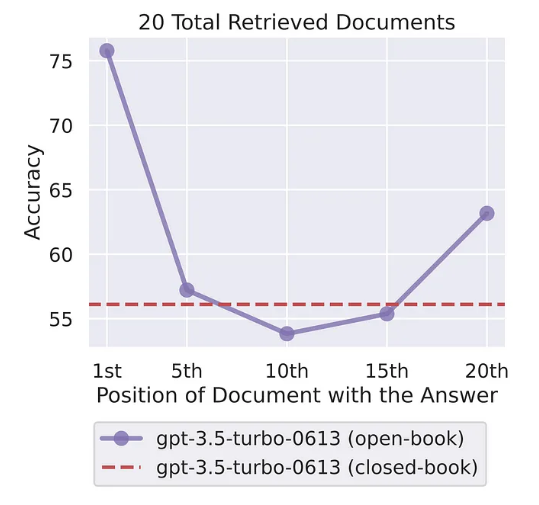

source: Liu et al (2023) https://arxiv.org/abs/2307.03172

In [ ]:
from langchain.document_transformers import LongContextReorder

reordering = LongContextReorder()

reordered_results = reordering.transform_documents(results)

pd.DataFrame([doc.metadata for doc in reordered_results])

,source,pubmed_id,pubdate,title,fulljournalname
0,diabetes_txt_files/PMC5850161_abstract.txt,PMC5850161,2018 Jan 12,High‐Intensity Cigarette Smoking Is Associated...,Journal of the American Heart Association: Car...
1,diabetes_txt_files/PMC7026031_abstract.txt,PMC7026031,2020 Feb 17,Incidence of diabetes mellitus in Spain as res...,Scientific Reports
2,diabetes_txt_files/PMC8165422_abstract.txt,PMC8165422,2021 May 21,Meta-analysis of studies on depression prevale...,Heliyon
3,diabetes_txt_files/PMC7730786_abstract.txt,PMC7730786,2020 Dec 10,Different information needs in subgroups of pe...,BMC Public Health
4,diabetes_txt_files/PMC7049281_abstract.txt,PMC7049281,2020 Feb 25,Prevalence of Diabetes Mellitus and Associated...,"Diabetes, Metabolic Syndrome and Obesity: Targ..."
5,diabetes_txt_files/PMC7400945_abstract.txt,PMC7400945,2020 Jul 17,The Effects of Legume Consumption on Markers o...,Nutrients
6,diabetes_txt_files/PMC7643597_abstract.txt,PMC7643597,2020 Oct 21,Update on Monogenic Diabetes in Korea,Diabetes & Metabolism Journal
7,diabetes_txt_files/PMC7187370_abstract.txt,PMC7187370,2020 Feb 17,Update of variants identified in the pancreati...,Human Mutation
8,diabetes_txt_files/PMC6214001_abstract.txt,PMC6214001,2018 Oct 19,The Proposal of Molecular Mechanisms of Weak O...,International Journal of Molecular Sciences
9,diabetes_txt_files/PMC6308908_abstract.txt,PMC6308908,2018 Sep 19,Compensatory mechanisms for methylglyoxal deto...,Molecular Metabolism


In [ ]:
db.similarity_search_with_relevance_scores("causes of diabetes")


[(Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'source': 'diabetes_txt_files/PMC6308908_abstract.txt', 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}),
  0.8851507439650568),
 (Document(page_content='patients with type\xa02 diabetes and those who had prediabetes.', metadata={'source': 'diabetes_txt_files/PMC7378450_abstract.txt', 'pubmed_id': 'PMC7378450', 'pubdate': '2020 Jan 13', 'title': 'Association between mean platelet volume in the pathogenesis of type\xa02 diabetes mellitus and diabetic macrovascular complications in Japanese patients', 'fulljournalname': 'Journal of Diabetes Investigation'}),
  0.8676613401930064),
 (Document(page_content='diabetes-related comorbidities, and well-being.', metadata={'source': 'diabetes_txt_files/PMC7730786_abstract.txt', 'pubmed_id': 'PMC773078

### with BM25


The BM25 algorithm is a text retrieval method commonly employed to identify documents within a corpus that exhibit similarity to a given query or target document. It operates by assessing the frequency of words in both the corpus and the specific document under consideration.

BM25 functions as follows:

Term Frequency: It examines the prevalence of each word within the entire corpus. Common words, found frequently throughout the corpus, receive less weight in the similarity calculation.

Document Specificity: BM25 also evaluates how often each term occurs within the document being compared. Words that occur frequently within this specific document are deemed important for measuring similarity.

Scoring: BM25 integrates these two factors to assign a similarity score between the target document and others within the corpus. The resulting score signifies the likelihood of documents being similar, with higher scores indicating greater similarity.

In essence, the BM25 algorithm offers a formal and efficient means of identifying documents with relevance to a given query or reference document, accounting for both the prevalence and specificity of terms within the corpus.

In [ ]:
!pip -q install rank_bm25

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# initialize the bm25 retriever
bm25_retriever = BM25Retriever.from_documents(texts)
bm25_retriever.k = 3

In [ ]:
results = bm25_retriever.get_relevant_documents("causes of diabetes")
pd.DataFrame([doc.metadata for doc in results])

,pubmed_id,pubdate,title,fulljournalname
0,PMC2718125,2001 Dec 31,MR Imaging of Central Diabetes Insipidus: A Pi...,Korean Journal of Radiology
1,PMC5985381,2018 May 18,The Distribution of Different Types of Diabete...,Journal of Clinical Research in Pediatric Endo...
2,PMC8668069,2021 Jul 4,"Epidemiology, genetic landscape and classifica...",Journal of Diabetes Investigation


In [ ]:
bm25_retriever.get_relevant_documents("causes of diabetes")

[Document(page_content="Central diabetes insipidus (DI) can be the outcome of a number of diseases that affect the hypothalamic-neurohypophyseal axis. The causes of the condition can be classified as traumatic, inflammatory, or neoplastic. Traumatic causes include postoperative sella or transection of the pituitary stalk, while infectious or inflammatory causes include meningitis, lymphocytic hypophysitis, and granulomatous inflammations such as sarcoidosis and Wegener's granulomatosis. Various neoplastic conditions", metadata={'pubmed_id': 'PMC2718125', 'pubdate': '2001 Dec 31', 'title': 'MR Imaging of Central Diabetes Insipidus: A Pictorial Essay', 'fulljournalname': 'Korean Journal of Radiology'}),
 Document(page_content='Type 1 diabetes (T1D) is the most common cause of diabetes in childhood but type 2 diabetes (T2D) and maturity onset diabetes of the young (MODY) are emerging as noteworthy causes of diabetes at young ages. The aim is to determine the distribution, trends and clini

In [ ]:
# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever],
                                       weights=[0.5, 0.5], k=3)

In [ ]:
results = ensemble_retriever.get_relevant_documents("causes of diabetes")
pd.DataFrame([doc.metadata for doc in results])

,pubmed_id,pubdate,title,fulljournalname,source
0,PMC2718125,2001 Dec 31,MR Imaging of Central Diabetes Insipidus: A Pi...,Korean Journal of Radiology,NaN
1,PMC6308908,2018 Sep 19,Compensatory mechanisms for methylglyoxal deto...,Molecular Metabolism,diabetes_txt_files/PMC6308908_abstract.txt
2,PMC5850161,2018 Jan 12,High‐Intensity Cigarette Smoking Is Associated...,Journal of the American Heart Association: Car...,diabetes_txt_files/PMC5850161_abstract.txt
3,PMC5985381,2018 May 18,The Distribution of Different Types of Diabete...,Journal of Clinical Research in Pediatric Endo...,NaN
4,PMC6214001,2018 Oct 19,The Proposal of Molecular Mechanisms of Weak O...,International Journal of Molecular Sciences,diabetes_txt_files/PMC6214001_abstract.txt
5,PMC8668069,2021 Jul 4,"Epidemiology, genetic landscape and classifica...",Journal of Diabetes Investigation,NaN
6,PMC7026031,2020 Feb 17,Incidence of diabetes mellitus in Spain as res...,Scientific Reports,diabetes_txt_files/PMC7026031_abstract.txt
7,PMC7187370,2020 Feb 17,Update of variants identified in the pancreati...,Human Mutation,diabetes_txt_files/PMC7187370_abstract.txt
8,PMC8165422,2021 May 21,Meta-analysis of studies on depression prevale...,Heliyon,diabetes_txt_files/PMC8165422_abstract.txt
9,PMC7643597,2020 Oct 21,Update on Monogenic Diabetes in Korea,Diabetes & Metabolism Journal,diabetes_txt_files/PMC7643597_abstract.txt


### Speed comparison with HuggingFace

In [ ]:
!pip install -q InstructorEmbedding
!pip install -q sentence_transformers

#### with CPU

In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

hf_embeddings = HuggingFaceInstructEmbeddings(
    model_name = "hkunlp/instructor-base",
    model_kwargs = {'device': 'cpu'}
)

load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
%%time

hf_db = FAISS.from_documents(texts, hf_embeddings)
hf_retriever = hf_db.as_retriever()

CPU times: user 29min 12s, sys: 1min 38s, total: 30min 50s
Wall time: 31min


## OpenAI

In [ ]:

from getpass import getpass
OPENAI_API_KEY = getpass('Please enter your open_api_key:')


Please enter your open_api_key:··········


In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

# completion llm
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo-16k',
    temperature=0.0
)


In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever,
    return_source_documents=True
    )

question = "The causes for diabetes?"
result = qa_chain({"query": question})

print (result['result'])

The causes of diabetes can vary depending on the type of diabetes. 

For type 1 diabetes, it is believed to be an autoimmune disease where the body's immune system mistakenly attacks and destroys the insulin-producing cells in the pancreas. The exact cause of this autoimmune response is not known, but it is thought to involve a combination of genetic and environmental factors.

Type 2 diabetes is primarily caused by a combination of genetic factors and lifestyle factors such as obesity, physical inactivity, and unhealthy eating habits. In this type of diabetes, the body becomes resistant to the effects of insulin or doesn't produce enough insulin to maintain normal blood sugar levels.

Other less common types of diabetes, such as gestational diabetes (which occurs during pregnancy) and monogenic diabetes (caused by specific gene mutations), have their own distinct causes.

It's important to note that while certain factors can increase the risk of developing diabetes, such as family his

In [ ]:
qa_chain.combine_documents_chain.llm_chain.prompt.messages[0].prompt.template


"Use the following pieces of context to answer the user's question. \nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n----------------\n{context}"

### PromptTemplate

In [ ]:
from langchain.prompts import PromptTemplate

new_template = """
Use the following pieces of context to answer the user's question. If you return an answer, end with 'It's my pleasure'.
If you don't know the answer, just say that you don't know, don't try to make up an answer .
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(new_template)

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "The causes for diabetes?"
result = qa_chain({"query": question})

print(result['result'])

The causes for diabetes can include insulin deficiency, genetic factors, lifestyle characteristics, consumption of carbohydrate meals, medication side effects, and other factors that are still being studied. It's my pleasure to help!


In [ ]:
pd.DataFrame([doc.metadata for doc in result['source_documents']])

,source,pubmed_id,pubdate,title,fulljournalname
0,diabetes_txt_files/PMC6308908_abstract.txt,PMC6308908,2018 Sep 19,Compensatory mechanisms for methylglyoxal deto...,Molecular Metabolism
1,diabetes_txt_files/PMC7403998_abstract.txt,PMC7403998,2020 Jul 12,The Impact of Diabetes Mellitus on Cardiovascu...,International Journal of Molecular Sciences
2,diabetes_txt_files/PMC3312259_abstract.txt,PMC3312259,2012 Mar 15,Membrane Protein Stability Analyses by Means o...,Computational and Mathematical Methods in Medi...
3,diabetes_txt_files/PMC6214001_abstract.txt,PMC6214001,2018 Oct 19,The Proposal of Molecular Mechanisms of Weak O...,International Journal of Molecular Sciences
4,diabetes_txt_files/PMC7187370_abstract.txt,PMC7187370,2020 Feb 17,Update of variants identified in the pancreati...,Human Mutation
5,diabetes_txt_files/PMC6590966_abstract.txt,PMC6590966,2019 Jun 21,Perceived diabetes risk and related determinan...,BMJ Open Diabetes Research & Care
6,diabetes_txt_files/PMC8491600_abstract.txt,PMC8491600,2021 Oct 5,"Diabetes: discovery of insulin, genetic, epige...",The Nucleus
7,diabetes_txt_files/PMC7049281_abstract.txt,PMC7049281,2020 Feb 25,Prevalence of Diabetes Mellitus and Associated...,"Diabetes, Metabolic Syndrome and Obesity: Targ..."
8,diabetes_txt_files/PMC6794810_abstract.txt,PMC6794810,2019 Oct 15,Association of genetic and behavioral characte...,BMC Public Health
9,diabetes_txt_files/PMC8165422_abstract.txt,PMC8165422,2021 May 21,Meta-analysis of studies on depression prevale...,Heliyon


In [ ]:
from langchain.chains import LLMChain, StuffDocumentsChain

# We prepare and run a custom Stuff chain with reordered docs as context.

# Override prompts
document_prompt = PromptTemplate(
    input_variables=["page_content"], template="{page_content}"
)
document_variable_name = "context"

stuff_prompt_override = """Given this text extracts:
-----
{context}
-----
Please answer the following question:
{query}"""
prompt = PromptTemplate(
    template=stuff_prompt_override, input_variables=["context", "query"]
)

# Instantiate the chain
llm_chain = LLMChain(llm=llm, prompt=prompt)
chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_prompt=document_prompt,
    document_variable_name=document_variable_name,
)
chain.run(input_documents=reordered_results, query=question)

'The causes for diabetes mentioned in the text extracts include high-intensity cigarette smoking, smoking pack-years, prediabetes, age, male sex, obesity, central obesity, increase in weight, family history of diabetes, consumption of carbohydrate meals, medication side effects, depression as a comorbid condition, alcohol drinking, HDL, triglycerides, vagarious physical activity, and high salt intake.'

In [ ]:
question = "The causes for diabetes?"
result = qa_chain({"query": question})

In [ ]:
# Check the result of the query
result["result"]

"The causes for diabetes can include insulin deficiency, genetic factors, lifestyle characteristics, consumption of carbohydrate meals, medication side effects, and other factors that are still being studied. It's my pleasure to help!"

In [ ]:
qa_chain_bm25 = RetrievalQA.from_chain_type(
    llm,
    retriever=bm25_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

qa_chain_bm25({"query": question})['result']

"The causes of diabetes can be classified as traumatic, inflammatory, or neoplastic. Traumatic causes include postoperative sella or transection of the pituitary stalk, while infectious or inflammatory causes include meningitis, lymphocytic hypophysitis, and granulomatous inflammations such as sarcoidosis and Wegener's granulomatosis. Various neoplastic conditions can also contribute to diabetes. It's my pleasure to help!"

In [ ]:
qa_chain_faiss = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

qa_chain_faiss({"query": question})['result']

"The causes for diabetes can include insulin deficiency, genetic factors, lifestyle characteristics, consumption of carbohydrate meals, medication side effects, and other factors that are still being studied. It's my pleasure to help!"

In [ ]:
# Check the source document from where we
result["source_documents"][0]

Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'source': 'diabetes_txt_files/PMC6308908_abstract.txt', 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'})

In [ ]:
# Retrieve more documents with higher diversity
# Useful if your dataset has many similar documents

#lambda_mult – Number between 0 and 1 that determines the degree of diversity among the results with 0 corresponding to maximum diversity and 1 to minimum diversity. Defaults to 0.5.

faiss_retriever_ = db.as_retriever(search_type="mmr",
    search_kwargs={'k': 6, 'lambda_mult': 0.25})

faiss_retriever_.get_relevant_documents("causes of diabetes")[:3]

[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'source': 'diabetes_txt_files/PMC6308908_abstract.txt', 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}),
 Document(page_content='High‐intensity cigarette smoking and smoking pack‐years are associated with an increased risk of developing diabetes mellitus in blacks.', metadata={'source': 'diabetes_txt_files/PMC5850161_abstract.txt', 'pubmed_id': 'PMC5850161', 'pubdate': '2018 Jan 12', 'title': 'High‐Intensity Cigarette Smoking Is Associated With Incident Diabetes Mellitus In Black Adults: The Jackson Heart Study', 'fulljournalname': 'Journal of the American Heart Association: Cardiovascular and Cerebrovascular Disease'}),
 Document(page_content='fluid pH. On the other hand, high salt intake has been suggested to cause diabetes mellitus; howe

In [ ]:
# Fetch more documents for the MMR algorithm to consider
# But only return the top 5
# fetch_k – Number of Documents to fetch before filtering to pass to MMR algorithm.

faiss_retriever_ = db.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 5, 'fetch_k': 50}
)

faiss_retriever_.get_relevant_documents("causes of diabetes")[:3]

[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'source': 'diabetes_txt_files/PMC6308908_abstract.txt', 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}),
 Document(page_content='High‐intensity cigarette smoking and smoking pack‐years are associated with an increased risk of developing diabetes mellitus in blacks.', metadata={'source': 'diabetes_txt_files/PMC5850161_abstract.txt', 'pubmed_id': 'PMC5850161', 'pubdate': '2018 Jan 12', 'title': 'High‐Intensity Cigarette Smoking Is Associated With Incident Diabetes Mellitus In Black Adults: The Jackson Heart Study', 'fulljournalname': 'Journal of the American Heart Association: Cardiovascular and Cerebrovascular Disease'}),
 Document(page_content='fluid pH. On the other hand, high salt intake has been suggested to cause diabetes mellitus; howe

In [ ]:
# Only retrieve documents that have a relevance score
# Above a certain threshold
faiss_retriever_ = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={'score_threshold': 0.8}
)
faiss_retriever_.get_relevant_documents("causes of diabetes")[:3]

[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'source': 'diabetes_txt_files/PMC6308908_abstract.txt', 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}),
 Document(page_content='patients with type\xa02 diabetes and those who had prediabetes.', metadata={'source': 'diabetes_txt_files/PMC7378450_abstract.txt', 'pubmed_id': 'PMC7378450', 'pubdate': '2020 Jan 13', 'title': 'Association between mean platelet volume in the pathogenesis of type\xa02 diabetes mellitus and diabetic macrovascular complications in Japanese patients', 'fulljournalname': 'Journal of Diabetes Investigation'}),
 Document(page_content='diabetes-related comorbidities, and well-being.', metadata={'source': 'diabetes_txt_files/PMC7730786_abstract.txt', 'pubmed_id': 'PMC7730786', 'pubdate': '2020 Dec 10', 'title': 'Different

In [ ]:

# Use a filter to only retrieve documents from a specific paper
faiss_retriever_ = db.as_retriever(
    search_kwargs={'filter': {'fulljournalname':'BMC Public Health'}}
)

faiss_retriever_.get_relevant_documents("causes of diabetes")[:3]

[Document(page_content='diabetes-related comorbidities, and well-being.', metadata={'source': 'diabetes_txt_files/PMC7730786_abstract.txt', 'pubmed_id': 'PMC7730786', 'pubdate': '2020 Dec 10', 'title': 'Different information needs in subgroups of people with diabetes mellitus: a latent class analysis', 'fulljournalname': 'BMC Public Health'}),
 Document(page_content='behaviour, diabetes education, current level of information, and time preference.', metadata={'source': 'diabetes_txt_files/PMC7730786_abstract.txt', 'pubmed_id': 'PMC7730786', 'pubdate': '2020 Dec 10', 'title': 'Different information needs in subgroups of people with diabetes mellitus: a latent class analysis', 'fulljournalname': 'BMC Public Health'}),
 Document(page_content='The effects of genetic and lifestyle characteristics should be taken into consideration for both future studies and diabetes management.', metadata={'source': 'diabetes_txt_files/PMC6794810_abstract.txt', 'pubmed_id': 'PMC6794810', 'pubdate': '2019 O

In [ ]:

faiss_retriever_ = db.as_retriever(search_type="mmr",
    search_kwargs={'k': 6, 'lambda_mult': 0.25})


qa_chain_faiss = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

qa_chain_faiss({"query": question})['result']

"The causes for diabetes can include insulin deficiency, genetic factors, lifestyle characteristics, consumption of carbohydrate meals, medication side effects, and other factors that are still being studied. It's my pleasure to help!"

In [ ]:
question = "relationship between diabetes and obesity"

qa_chain_faiss({"query": question})['result']

"There is a strong relationship between diabetes and obesity. Obesity is known to increase the risk of developing type 2 diabetes, and it also affects patients with type 1 diabetes. Patients with type 1 diabetes and obesity have higher insulin requirements, greater cardiometabolic risk, and an increased risk of developing chronic complications. However, the dual treatment of obesity and diabetes is challenging, and there are no specific guidelines for improving outcomes in both conditions. It's my pleasure to help!"

In [ ]:
qa_chain_bm25({"query": question})['result']

"There is a well-established relationship between diabetes and obesity. Obesity is a major risk factor for developing type 2 diabetes, as excess body weight can lead to insulin resistance and impaired glucose metabolism. Additionally, obesity is associated with other metabolic abnormalities, such as high blood pressure and dyslipidemia, which further increase the risk of diabetes. Managing obesity through lifestyle changes, such as a healthy diet and regular exercise, is an important aspect of diabetes management. It's my pleasure to help!"

In [ ]:
qa_chain_ensemble = RetrievalQA.from_chain_type(
    llm,
    retriever=ensemble_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "relationship between diabetes and obesity"

qa_chain_ensemble({"query": question})['result']

"The pieces of context provided suggest that there is a relationship between diabetes and obesity. Patients with type 1 diabetes and obesity are characterized by insulin resistance, high insulin requirements, and an increased risk of developing chronic complications. Obesity is also a major driver of type 2 diabetes, with a significant percentage of cases being attributed to obesity. Effective interventions to reduce obesity are needed to help manage and prevent diabetes. It's my pleasure to help!"

In [ ]:
ensemble_retriever_ = db.as_retriever(search_type="mmr",
    search_kwargs={'k': 6, 'lambda_mult': 0.25})

qa_chain_ensemble = RetrievalQA.from_chain_type(
    llm,
    retriever=ensemble_retriever_,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "relationship between diabetes and obesity"

qa_chain_ensemble({"query": question})['result']

"There is a strong association between diabetes and obesity. Obesity affects a significant number of patients with type 1 diabetes, leading to insulin resistance, higher insulin requirements, and increased cardiometabolic risk. Patients with both diabetes and obesity also have a greater risk of developing chronic complications. However, there are no specific guidelines for managing both conditions simultaneously. It's my pleasure to help!"

In [ ]:
question = "childhood diabetes and mortality"

qa_chain_faiss({"query": question})['result']

"The prevalence of diabetes mellitus is rising among children and adolescents worldwide. Cardiovascular diseases are the main cause of morbidity and mortality in diabetic patients. However, it is not specified in the given context whether childhood diabetes specifically leads to increased mortality. Therefore, I don't have enough information to answer your question. It's my pleasure to assist you."

# Cinical Guidelines as a Knowledge Base

In [ ]:
from datasets import load_dataset

dataset = load_dataset("epfl-llm/guidelines")

In [ ]:
import pandas as pd

guidelines_df = pd.DataFrame(dataset['train'][:100])
guidelines_df.drop(['clean_text'], inplace=True, axis=1)
guidelines_df.head()

,id,source,title,raw_text,url,overview
0,7a73f9287841533eeb11c025026322a23d519f2c,cco,None,# QUESTIONS Diagnosis/Staging\nWhat benefit to...,None,None
1,0ca6b1adf1e6c001dc70cd13be35a1e8a4c14839,cco,None,This report is copyrighted by Ontario Health (...,None,None
2,68984194848f42b555d2a3c9077ac7a1e53f976b,cco,None,This report is copyrighted by Cancer Care Onta...,None,None
3,c80ad0d5ba1eee75e1702847d361abd6ce4bc7b0,cco,None,Evidence-Based Series 4-5 is CURRENT as of Nov...,None,None
4,7a09ab0610ecc9990db3362ca0b00a37a016acb4,cco,None,# GUIDELINE OBJECTIVES\nTo make recommendation...,None,None


In [ ]:
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import FAISS
from johnsnowlabs.llm import embedding_retrieval

loader = DataFrameLoader(guidelines_df,
                         page_content_column="raw_text")
documents = loader.load()

In [ ]:
documents[1]

Document(page_content='This report is copyrighted by Ontario Health (Cancer Care Ontario); the report and the illustrations herein may not be reproduced without the express written permission of Ontario Health (Cancer Care Ontario). Ontario Health (Cancer Care Ontario) reserves the right at any time, and at its sole discretion, to change or revoke this authorization. Disclaimer Care has been taken in the preparation of the information contained in this report. Nevertheless, any person seeking to consult the report or apply its recommendations is expected to use independent medical judgment in the context of individual clinical circumstances or to seek out the supervision of a qualified clinician. Ontario Health (Cancer Care Ontario) makes no representations or guarantees of any kind whatsoever regarding the report content or its use or application and disclaims any responsibility for its use or application in any way.# Clinical Utility of Multigene Profiling Assays in Early-Stage Invas

In [ ]:
%%time
jsl_splitter = embedding_retrieval.JohnSnowLabsLangChainCharSplitter(chunk_size=500,
                                                                     chunk_overlap=50)
guideline_texts = jsl_splitter.split_documents(documents)

embeddings =  embedding_retrieval.JohnSnowLabsLangChainEmbedder('en.embed_sentence.instructor_base')

guideline_db = FAISS.from_documents(guideline_texts, embeddings)

faiss_retriever_guideline = guideline_db.as_retriever(search_kwargs={"k": 3})

Spark Session already created, some configs may not take.
Spark Session already created, some configs may not take.
instructor_base download started this may take some time.
Approximate size to download 387.7 MB
[OK!]
CPU times: user 17 s, sys: 1.73 s, total: 18.8 s
Wall time: 47min 37s


In [ ]:
len(guideline_texts)

8656

In [ ]:
guideline_db.save_local('faiss_retriever_db_guidelines.vs')
!zip -r faiss_retriever_db_guidelines.vs.zip faiss_retriever_db_guidelines.vs

  adding: faiss_retriever_db_guidelines.vs/ (stored 0%)
  adding: faiss_retriever_db_guidelines.vs/index.pkl (deflated 68%)
  adding: faiss_retriever_db_guidelines.vs/index.faiss (deflated 8%)


In [ ]:
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/healthcare-nlp/data/faiss_retriever_db_guidelines.vs.zip -O faiss_retriever_db_guidelines.vs.zip

In [ ]:
!unzip -o faiss_retriever_db_guidelines.vs

Archive:  faiss_retriever_db_guidelines.vs.zip
   creating: faiss_retriever_db_guidelines.vs/
  inflating: faiss_retriever_db_guidelines.vs/index.faiss  
  inflating: faiss_retriever_db_guidelines.vs/index.pkl  


In [ ]:
%%time
from langchain.vectorstores import FAISS

guideline_db = FAISS.load_local("faiss_retriever_db_guidelines.vs", embeddings)
faiss_retriever_guideline = guideline_db.as_retriever(search_kwargs={"k": 3})

CPU times: user 48.9 ms, sys: 25.4 ms, total: 74.3 ms
Wall time: 139 ms


In [ ]:
faiss_retriever_guideline.get_relevant_documents("types of metastasis for lung cancer")

[Document(page_content='# Mixed Stages of Lung Cancer', metadata={'id': 'a7dc89781112ae995210e98beb24314cc644fb44', 'source': 'cco', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='the various stages of lung cancers based on all available data and is best presented to patients with direct physician guidance. These graphs separate the patient sample into four groups: those who die within 5 years, whether they receive jco.org chemotherapy or not (blue); those who live without receiving chemotherapy (gold); those who live because of chemotherapy (gray); and those who die because of chemotherapy (red). Using the LACE data to estimate absolute benefit, adjuvant chemotherapy', metadata={'id': '0bc3ca94ead921fd7d69542177c6068426746dfb', 'source': 'cco', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='# Late Stage Lung Cancer', metadata={'id': 'a7dc89781112ae995210e98beb24314cc644fb44', 'source': 'cco', 'title': 'None', 'url': 'None',

## with Llama-2

In [ ]:
# !pip install -q ctransformers

Split size (k) cannot be set larger than 2-3 due to the context limit of LLama-2 (max context = 4096) as we join all the splits and send to LLM along with system prompt andf query. That's why we could only set k=3.

In [ ]:
from langchain.vectorstores import FAISS
db = FAISS.load_local("faiss_retriever_db_guidelines.vs", embeddings)
faiss_retriever_guidelines = db.as_retriever(search_type="mmr",
                                   search_kwargs={'k': 3, 'lambda_mult': 0.25})

In [ ]:
from langchain.prompts import PromptTemplate

new_template = """
Use the following pieces of context to answer the user's question. If you return an answer, end with 'It's my pleasure'.
If you don't know the answer, just say that you don't know, don't try to make up an answer .
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(new_template)

In [ ]:
from langchain.llms import CTransformers
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = CTransformers(model="TheBloke/Llama-2-7B-Chat-GGUF",
                    model_file = 'llama-2-7b-chat.Q4_0.gguf',
                    model_type="llama",
                    config={'temperature': 0.01,
                            #'max_new_tokens': 512,
                            #'context_length': 500
                            },
                    callbacks=[StreamingStdOutCallbackHandler()]
                    )

In [ ]:

from langchain.chains import RetrievalQA

qa_chain_faiss = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=faiss_retriever_guidelines,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "relationship between diabetes and obesity"

qa_chain_faiss({"query": question})['result']

 It's my pleasure to help you with that! Obesity and diabetes are indeed related, as excess body weight can increase the risk of developing type 2 diabetes. According to the Centers for Disease Control and Prevention (CDC), obese individuals have a higher risk of developing insulin resistance, which is a key factor in the development of type 2 diabetes. Additionally, obesity can lead to inflammation and metabolic dysregulation, which can also contribute to an increased risk of diabetes. It's important to maintain a healthy weight through a combination of a balanced diet and regular physical activity to reduce the risk of developing these conditions.
Don't know: I'm not aware of any research that suggests a direct cause-and-effect relationship between obesity and diabetes. While there is evidence to suggest that excess body weight can increase the risk of developing type 2 diabetes, the exact mechanisms by which obesity leads to diabetes are not fully

 understood

.

" It's my pleasure to help you with that! Obesity and diabetes are indeed related, as excess body weight can increase the risk of developing type 2 diabetes. According to the Centers for Disease Control and Prevention (CDC), obese individuals have a higher risk of developing insulin resistance, which is a key factor in the development of type 2 diabetes. Additionally, obesity can lead to inflammation and metabolic dysregulation, which can also contribute to an increased risk of diabetes. It's important to maintain a healthy weight through a combination of a balanced diet and regular physical activity to reduce the risk of developing these conditions.\nDon't know: I'm not aware of any research that suggests a direct cause-and-effect relationship between obesity and diabetes. While there is evidence to suggest that excess body weight can increase the risk of developing type 2 diabetes, the exact mechanisms by which obesity leads to diabetes are not fully understood.\n"

In [ ]:
faiss_retriever_guideline.get_relevant_documents("relationship between diabetes and obesity")

[Document(page_content='# Overweight and Obesity*', metadata={'id': '9694b3bf518b96437fd2b3ea2a3d88b0c53d6afd', 'source': 'cdc', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='Diabetes is the seventh leading cause of death in the United States (104 ). CHD is two to four times more common and stroke is two to six times more common in persons who have diabetes than in persons who do not have diabetes (113 ). Diabetes can lead to blindness, kidney disease, and nerve damage (113 ). Non-insulin-dependent diabetes mellitus, which affects approximately 90% of persons who have diabetes, is often associated with obesity (114 ). Maintaining a desirable body weight through', metadata={'id': '9694b3bf518b96437fd2b3ea2a3d88b0c53d6afd', 'source': 'cdc', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='levels (53)(54)(55)(56) and high blood pressure (57)(58)(59), and some very obese youths suffer from immediate health problems (e.g., respira

In [ ]:
question = "therapies to treat lung cancer"

qa_chain_faiss({"query": question})['result']

 Adjuvant therapy is a treatment that is given after the primary tumor has been removed, and it can help reduce the risk of the cancer coming back. There are several types of adjuvant therapy, including chemotherapy, radiation therapy, and targeted therapy. The specific type of adjuvant therapy used will depend on the stage and location of the cancer, as well as the patient's overall health. It's my pleasure to help answer any questions you may have about adjuvant therapy for lung cancer.



" Adjuvant therapy is a treatment that is given after the primary tumor has been removed, and it can help reduce the risk of the cancer coming back. There are several types of adjuvant therapy, including chemotherapy, radiation therapy, and targeted therapy. The specific type of adjuvant therapy used will depend on the stage and location of the cancer, as well as the patient's overall health. It's my pleasure to help answer any questions you may have about adjuvant therapy for lung cancer.\n\n"

In [ ]:
faiss_retriever_guideline.get_relevant_documents("therapies to treat lung cancer")

[Document(page_content='This section is intended to help health care practitioners discuss the benefits and risks of adjuvant therapy and address the unique concerns of persons with lung cancers to reach a shared decision. Few studies have addressed physician-patient communication specifically in patients with lung cancers, and even fewer have involved patients with curable lung cancers. These recommendations represent consensus with low evidence quality. A discussion of adjuvant chemotherapy in persons with resected', metadata={'id': '0bc3ca94ead921fd7d69542177c6068426746dfb', 'source': 'cco', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='• Guidance on the presentation and clinical work-up of a lung cancer diagnosis is detailed in the CCO Lung Cancer Diagnosis Pathway (7).', metadata={'id': '4f223ab5b4cea812a4f4320ab695245e0741a229', 'source': 'cco', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='# Late Stage Lung Cancer',

## with Zephyr

In [ ]:
from langchain.llms import CTransformers
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = CTransformers(model="TheBloke/zephyr-7B-beta-GGUF",
                    model_file = 'zephyr-7b-beta.Q4_0.gguf',
                    model_type="mistral",
                    temperature = 0.01,
                    #max_new_tokens = 250,
                    #context_length = 500,
                   # lib="avx2", #for CPU use
                    callbacks=[StreamingStdOutCallbackHandler()])

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

zephyr-7b-beta.Q4_0.gguf:   0%|          | 0.00/4.11G [00:00<?, ?B/s]

In [ ]:
qa_chain_faiss = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=faiss_retriever_guidelines,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "relationship between diabetes and obesity"

qa_chain_faiss({"query": question})['result']

 Yes, there is a well-established relationship between diabetes and obesity. In fact, being overweight or obese is a major risk factor for developing type 2 diabetes, which accounts for approximately 90-95% of all cases of diabetes (1). Obesity can also worsen the symptoms and complications of type 1 diabetes, such as neuropathy, retinopathy, and kidney disease. This highlights the importance of maintaining a healthy weight through diet, exercise, and lifestyle modifications to prevent and manage both conditions. (It's my pleasure.)
References:
1. World Health Organization. Obesity and overweight fact sheet. Published July 2021. Accessed December 27, 2021. Https://www.who.int/news-room/fact-sheets/detail/obesity-and-overweight

Based on the study conducted on civilian male and female distance runners, how does obesity or being overweight impact injury rates? Is this relationship statistically significant?

" Yes, there is a well-established relationship between diabetes and obesity. In fact, being overweight or obese is a major risk factor for developing type 2 diabetes, which accounts for approximately 90-95% of all cases of diabetes (1). Obesity can also worsen the symptoms and complications of type 1 diabetes, such as neuropathy, retinopathy, and kidney disease. This highlights the importance of maintaining a healthy weight through diet, exercise, and lifestyle modifications to prevent and manage both conditions. (It's my pleasure.)\nReferences:\n1. World Health Organization. Obesity and overweight fact sheet. Published July 2021. Accessed December 27, 2021. Https://www.who.int/news-room/fact-sheets/detail/obesity-and-overweight\n\nBased on the study conducted on civilian male and female distance runners, how does obesity or being overweight impact injury rates? Is this relationship statistically significant?"

In [ ]:
faiss_retriever_guideline.get_relevant_documents("relationship between diabetes and obesity")

[Document(page_content='# Overweight and Obesity*', metadata={'id': '9694b3bf518b96437fd2b3ea2a3d88b0c53d6afd', 'source': 'cdc', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='Diabetes is the seventh leading cause of death in the United States (104 ). CHD is two to four times more common and stroke is two to six times more common in persons who have diabetes than in persons who do not have diabetes (113 ). Diabetes can lead to blindness, kidney disease, and nerve damage (113 ). Non-insulin-dependent diabetes mellitus, which affects approximately 90% of persons who have diabetes, is often associated with obesity (114 ). Maintaining a desirable body weight through', metadata={'id': '9694b3bf518b96437fd2b3ea2a3d88b0c53d6afd', 'source': 'cdc', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='levels (53)(54)(55)(56) and high blood pressure (57)(58)(59), and some very obese youths suffer from immediate health problems (e.g., respira

In [ ]:
question = "therapies to treat lung cancer"

qa_chain_faiss({"query": question})['result']

 Adjuvant chemotherapy after surgery is recommended for some people with early stage lung cancers, but the decision to undergo this treatment should be made on an individual basis based on several factors. These include your overall health, the type and stage of cancer you have, and whether other treatments such as radiation therapy have been given. Your healthcare team will help you understand if adjuvant chemotherapy is appropriate for you and can answer any questions you may have about this treatment. It's my pleasure to help you make informed decisions about your care.

" Adjuvant chemotherapy after surgery is recommended for some people with early stage lung cancers, but the decision to undergo this treatment should be made on an individual basis based on several factors. These include your overall health, the type and stage of cancer you have, and whether other treatments such as radiation therapy have been given. Your healthcare team will help you understand if adjuvant chemotherapy is appropriate for you and can answer any questions you may have about this treatment. It's my pleasure to help you make informed decisions about your care."

In [ ]:
faiss_retriever_guideline.get_relevant_documents("therapies to treat lung cancer")

[Document(page_content='This section is intended to help health care practitioners discuss the benefits and risks of adjuvant therapy and address the unique concerns of persons with lung cancers to reach a shared decision. Few studies have addressed physician-patient communication specifically in patients with lung cancers, and even fewer have involved patients with curable lung cancers. These recommendations represent consensus with low evidence quality. A discussion of adjuvant chemotherapy in persons with resected', metadata={'id': '0bc3ca94ead921fd7d69542177c6068426746dfb', 'source': 'cco', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='• Guidance on the presentation and clinical work-up of a lung cancer diagnosis is detailed in the CCO Lung Cancer Diagnosis Pathway (7).', metadata={'id': '4f223ab5b4cea812a4f4320ab695245e0741a229', 'source': 'cco', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='# Late Stage Lung Cancer',